In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


In [101]:
df = pd.read_excel("dado_teste.xlsx")

In [102]:
df.head()

,ds,y
0,2022-01-01,38311.000000
1,2022-02-01,41582.640000
2,2022-03-01,39149.590026
3,2022-04-01,38321.849216
4,2022-05-01,37903.416707


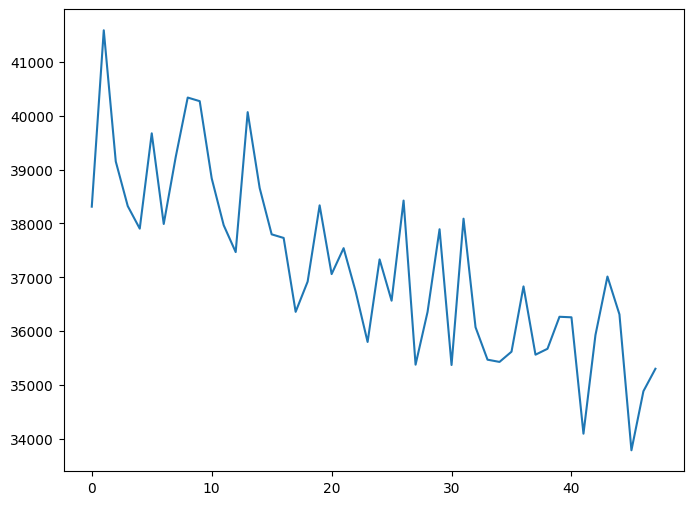

In [103]:
# Visão grafica da série completa
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df["y"])
plt.show()

In [104]:
len(df)

48

In [105]:
len(df)*0.75

36.0

In [106]:
treino = df.iloc[:36]
teste = df.iloc[36:]

### Hiperparâmetros do modelo
    * Changepoints: Determinados pontos específicos da série temporal em que ocorre uma mudança significativa no padrão dos dados. Essa mudança pode se manifestar como uma alteração na tendência, na sazonalidade ou em outros padrões presentes nos dados
    * Inicialmente, o modelo ajusta 25 pontos de forma uniforme. Os desenvolvedores nao recomendam ficar ajustando a quantidade de changepoints
* Ajustam-se os hiperparametros abaixo
    * Changepoint Prior Scale: Controla a flexibilidade do modelo ao ajustar os changepoints da série temporal, ou seja, o quanto a tendencia muda nos changepoints. Valores altos podem conduzir ao overfitting.
    * Seasonality Prior Scale:  Controla a flexibilidade da sazonalidade. Da mesma forma, um valor grande permite que a sazonalidade se ajuste a grandes flutuações, um valor pequeno diminui a magnitude da sazonalidade
    * Seasonality Mode: Modo da sazonalidade, sendo o "additive" apropriado para padroes sazonais que tem a mesma amplitude ao longo do tempo. O "multiplicative" é melhor para sazonalidades cuja amplitude varia ao longo do tempo

In [107]:
# Ajustando os valores possiveis de combinacao dos hiperparametros
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [108]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

### Validacao cruzada temporal
* O prophet permite a utilizacao de um metodo de validacao cruzada organizada de forma temporal
    * Initial: Dias da base que o modelo ira utilizar inicialmente para treinar o modelo
    * Horizon: dias a frente que o modelo fará a previsão para ser avaliado
    * O modelo utiliza, no exemplo abaixo:
        * Do dia 1 ate 360 para treinar
        * Preve do dia 361 até 450 (90 dias)
        * Incorpora 45 dias (metade da janela de previsao) ao treino, usando de 1 até 405
        * Preve do dia 406 até 495

In [109]:
from dask.distributed import Client
for params in all_params:
    m = Prophet(**params).fit(treino) 
    df_cv = cross_validation(m, initial = '360 days',  horizon = "90 days", parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0]) #colocando na lista o rmse de cada combinacao de parametros

21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:15:10 - cmdstanpy - INFO - Chain [1] start processing
21:15:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:15:16 - cmdstanpy - INFO - Chain [1] start processing
21:15:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:15:20 - cmdstanpy - INFO - Chain [1] start processing
21:15:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:15:26 - cmdstanpy - INFO - Chain [1] start processing
21:15:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

In [110]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [111]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [119]:
# Treinando o modelo com os melhores hiperparametros encontrados, utilizando todos os dados de treino disponiveis
my_model = Prophet(interval_width=0.95,
                   changepoint_prior_scale= 0.1, seasonality_prior_scale= 0.1, seasonality_mode= 'additive')

In [120]:
my_model.fit(treino)

21:34:13 - cmdstanpy - INFO - Chain [1] start processing
21:34:13 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
future_dates = my_model.make_future_dataframe(periods = 12, freq='MS')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,38233.659835,37234.304082,39180.374953
1,2022-02-01,40890.029581,39967.044686,41922.593060
2,2022-03-01,39803.856996,38772.883268,40784.738607
3,2022-04-01,38506.466989,37494.584604,39520.354624
4,2022-05-01,38677.329845,37653.605273,39671.333465


In [122]:
len(forecast)

48

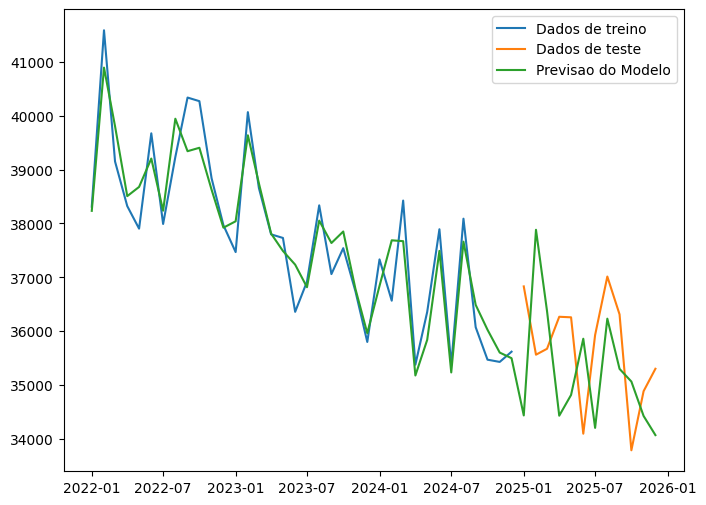

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(treino["ds"], treino["y"], label = "Dados de treino")
ax.plot(teste["ds"], teste["y"], label = 'Dados de teste')
ax.plot(forecast["ds"], forecast["yhat"], label = "Previsao do Modelo")
plt.legend()
plt.show()

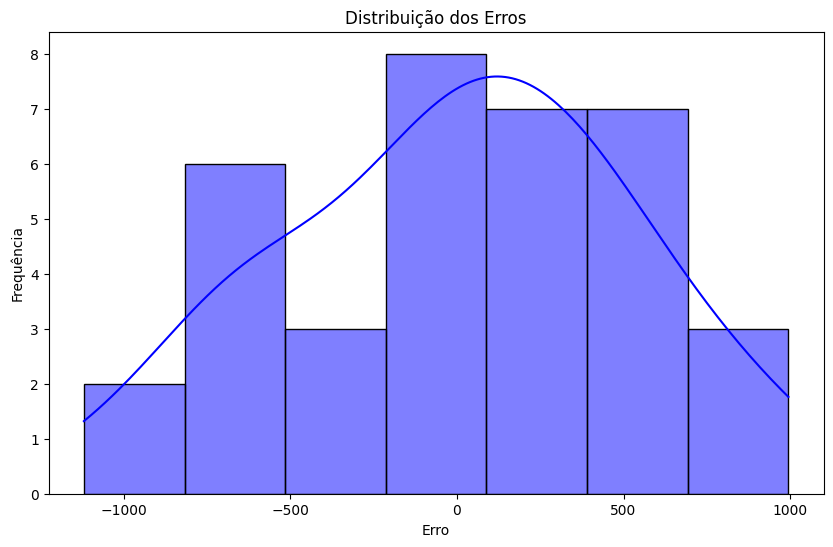

In [124]:
residuals = treino['y'] - forecast.loc[df.index[:304], 'yhat']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribuição dos Erros')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.show()

In [125]:
# RMSE das previsoes em relacao a base de teste
sqrt(mean_squared_error(teste['y'], forecast.loc[df.index[36:], 'yhat']))

1529.5692853448163

In [126]:
teste['y'].mean()

35662.19869965128

In [127]:
1529/35662

0.04287476866132017

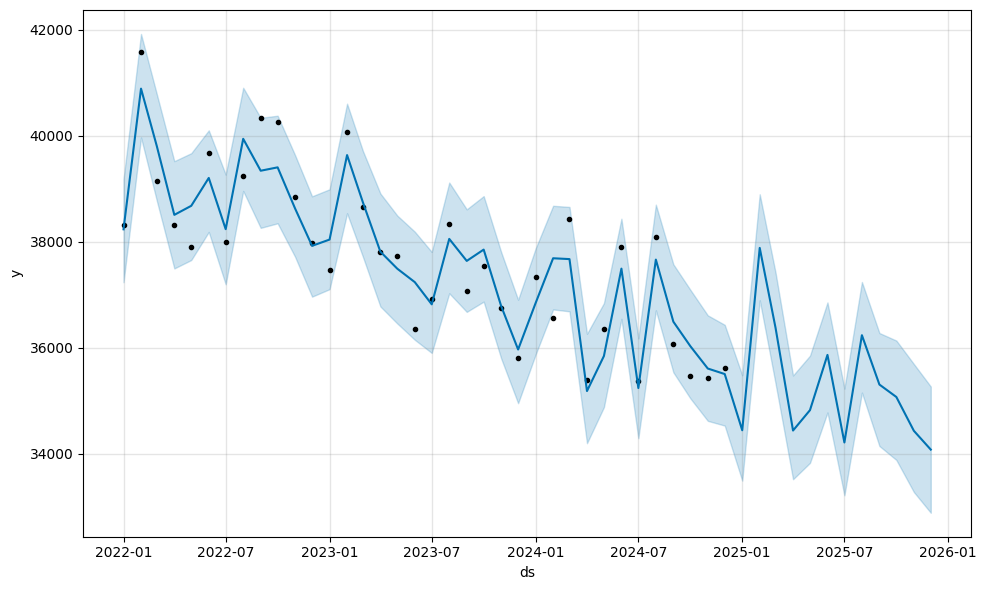

In [130]:
my_model.plot(forecast, uncertainty=True)
plt.show()

### Ajustando limites
* Se desejarmos, podemos estabelecer limites inferiores e superiores para nossas previsões

In [141]:
treino['cap'] = 45000 #limite superior
treino['floor'] = 35000 # limite inferior
# Neste caso, precisamos ajustar o parametro growth para 'logistic'
my_model2 = Prophet(interval_width=0.95,
                   changepoint_prior_scale= 0.1, seasonality_prior_scale= 0.1, seasonality_mode= 'additive', growth='logistic')
my_model2.fit(treino)

C:\Users\gcabr\AppData\Local\Temp\ipykernel_3376\3324749431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['cap'] = 45000 #limite superior
C:\Users\gcabr\AppData\Local\Temp\ipykernel_3376\3324749431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['floor'] = 35000 # limite inferior
21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:58 - cmdstanpy - INFO - Chain [1] done processing


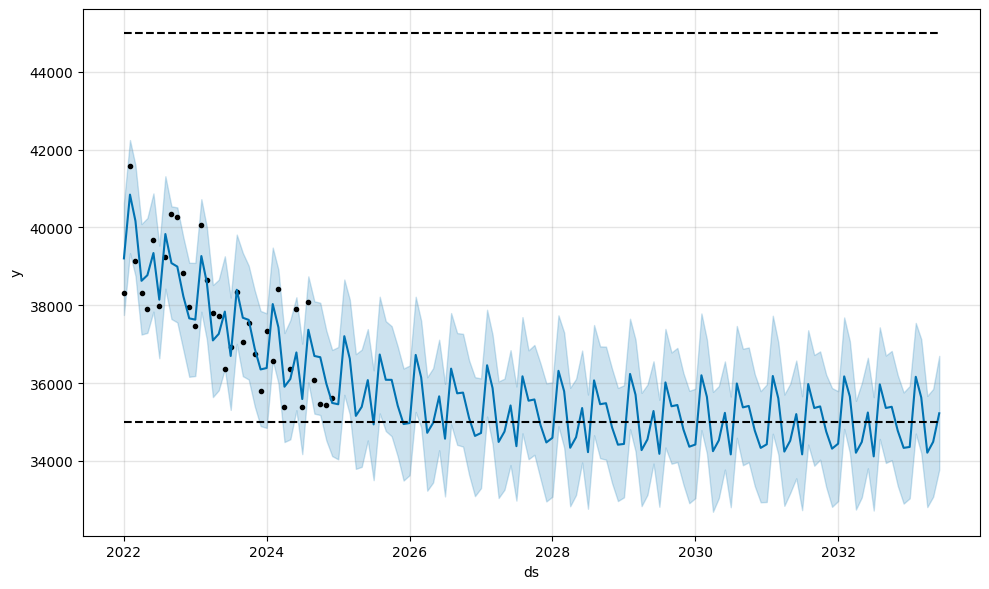

In [142]:
future_dates2 = my_model2.make_future_dataframe(periods=102, freq='MS')
future_dates2['cap'] = 45000
future_dates2['floor'] = 35000
fcst = my_model2.predict(future_dates2)
fig = my_model2.plot(fcst)